## Libs import

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Task 1 - EDA

### Data reading

In [3]:
data1 = pd.read_csv('data/data1.csv', index_col='DateTime')
data2 = pd.read_csv('data/data2.csv', index_col='DateTime')

### Data analysis

В условии сказано, что значения rho должны лежать в пределах [1.0, 2.5], предлагается пока не обращать внимание на несоблюдение этого условия.

In [4]:
# data1 = data1[(data1['ro1'] >= 1.0) & (data1['ro1'] <= 2.5) & \
#         (data1['ro2'] >= 1.0) & (data1['ro2'] <= 2.5) & \
#         (data1['ro3'] >= 1.0) & (data1['ro3'] <= 2.5) & \
#         (data1['ro4'] >= 1.0) & (data1['ro4'] <= 2.5)]
# data2 = data2[(data2['ro1'] >= 1.0) & (data2['ro1'] <= 2.5) & \
#         (data2['ro2'] >= 1.0) & (data2['ro2'] <= 2.5) & \
#         (data2['ro3'] >= 1.0) & (data2['ro3'] <= 2.5) & \
#         (data2['ro4'] >= 1.0) & (data2['ro4'] <= 2.5)]

data1.index = pd.to_datetime(data1.index)
data2.index = pd.to_datetime(data2.index)

#### data1

Проверка Nan

In [5]:
data1.isna().sum().sum(), data2.isna().sum().sum()

(0, 0)

Выведем количество данных, неудовлетворяющих условиям

In [6]:
data1[~((data2['ro1'] >= 1.0) & (data2['ro1'] <= 2.5) & \
      (data2['ro2'] >= 1.0) & (data2['ro2'] <= 2.5) & \
      (data2['ro3'] >= 1.0) & (data2['ro3'] <= 2.5) & \
      (data2['ro4'] >= 1.0) & (data2['ro4'] <= 2.5))].count().iloc[0], \
data2[~((data1['ro1'] >= 1.0) & (data1['ro1'] <= 2.5) & \
      (data1['ro2'] >= 1.0) & (data1['ro2'] <= 2.5) & \
      (data1['ro3'] >= 1.0) & (data1['ro3'] <= 2.5) & \
      (data1['ro4'] >= 1.0) & (data1['ro4'] <= 2.5))].count().iloc[0]

(282359, 282359)

Общее описание так себе выводить на "широких" фреймах, но по канону выведем

In [7]:
data1.describe()

,Ni1,S1,Fe3O41,Ni2,S2,Fe3O42,Ni3,S3,Fe3O43,Ni4,...,ro2,ro3,ro4,ro_final,ust1,ust2,ust3,ust4,v_final,level_final
count,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,...,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000,772067.000000
mean,5.477315,20.003626,1.951034,5.731805,17.743569,2.520591,7.547059,19.185887,2.681726,8.906555,...,1.699458,1.720863,1.873061,1.663788,17.495724,22.265632,27.880240,128.550099,134.460871,49.213927
std,1.174854,2.604641,0.765599,1.808937,3.004234,1.295176,1.334541,3.780063,1.232703,0.454001,...,0.478319,0.375284,0.384344,0.350396,14.590002,20.538308,20.696594,23.069860,83.669148,28.835602
min,3.660000,9.930000,0.200000,2.870000,7.970000,0.200000,4.130000,6.680000,0.300000,4.540000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.000000,0.000000,-1.000000
25%,4.690000,19.240000,1.500000,4.260000,16.460000,1.600000,6.480000,16.500000,2.100000,8.670000,...,1.227700,1.605000,1.749125,1.444900,0.000000,10.000000,10.000000,113.000000,9.000000,40.073300
50%,5.110000,20.400000,1.800000,5.110000,18.600000,2.000000,7.430000,18.800000,2.600000,8.900000,...,1.798000,1.791300,1.907450,1.841800,17.000000,14.000000,28.000000,125.000000,167.000000,56.605600
75%,5.950000,21.400000,2.200000,7.220000,19.600000,2.900000,8.450000,21.900000,3.500000,9.140000,...,2.038350,1.921450,2.127750,1.903700,26.000000,35.000000,44.000000,142.000000,191.000000,71.379700
max,9.600000,27.720000,6.200000,10.240000,29.540000,7.900000,10.890000,38.300000,8.700000,10.440000,...,2.997900,2.998100,2.995700,2.999800,81.000000,96.000000,96.000000,215.000000,285.000000,100.000000


Создадим словари для удобства:

In [8]:
columns_groups = {
  1: ['Ni1', 'S1', 'Fe3O41', 'ro1', 'ust1', 'ro_final', 'v_final', 'level_final'],
  2: ['Ni2', 'S2', 'Fe3O42', 'ro2', 'ust2', 'ro_final', 'v_final', 'level_final'],
  3: ['Ni3', 'S3', 'Fe3O43', 'ro3', 'ust3', 'ro_final', 'v_final', 'level_final'],
  4: ['Ni4', 'S4', 'Fe3O44', 'ro4', 'ust4', 'ro_final', 'v_final', 'level_final'],
}

columns_groups_no_final = {
  1: ['Ni1', 'S1', 'Fe3O41', 'ro1', 'ust1'],
  2: ['Ni2', 'S2', 'Fe3O42', 'ro2', 'ust2'],
  3: ['Ni3', 'S3', 'Fe3O43', 'ro3', 'ust3'],
  4: ['Ni4', 'S4', 'Fe3O44', 'ro4', 'ust4'],
}

columns_groups_entity = {
  1: ['Ni1', 'Ni2', 'Ni3', 'Ni4'],
  2: ['S1', 'S2', 'S3', 'S4'],
  3: ['ro1', 'ro2', 'ro3', 'ro4', 'ro_final'],
  4: ['Fe3O41', 'Fe3O42', 'Fe3O43', 'Fe3O44'],
  5: ['ust1', 'ust2', 'ust3', 'ust4'],
}

Формируем матрицы ковариаций для анализа предполагаемых линейных зависимостей в признаках

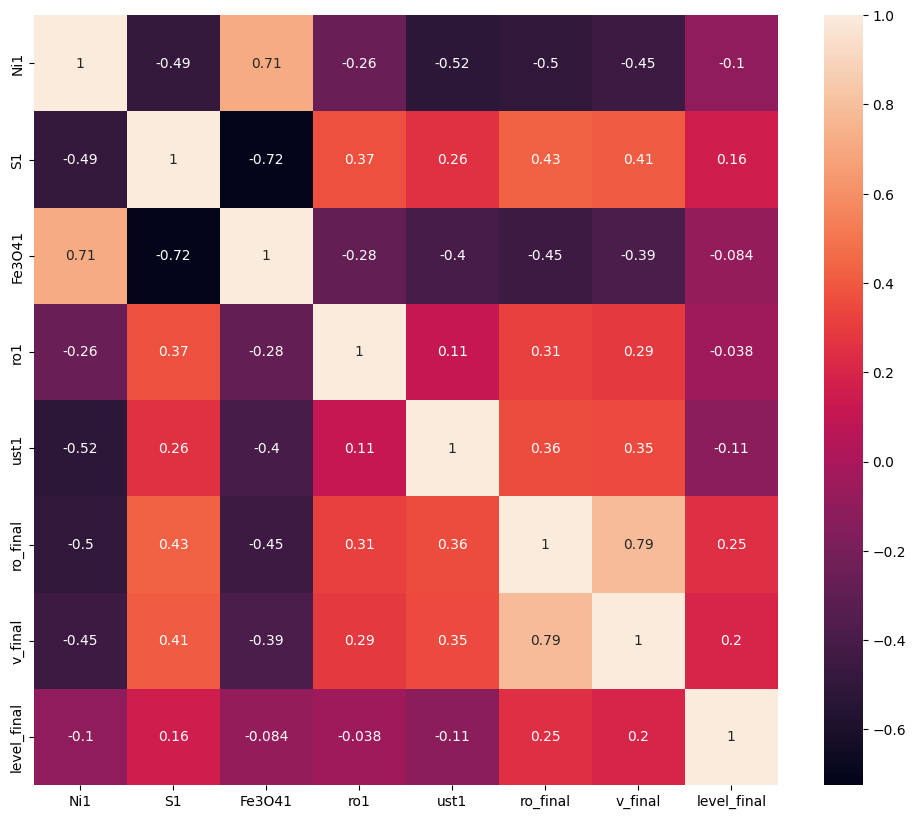

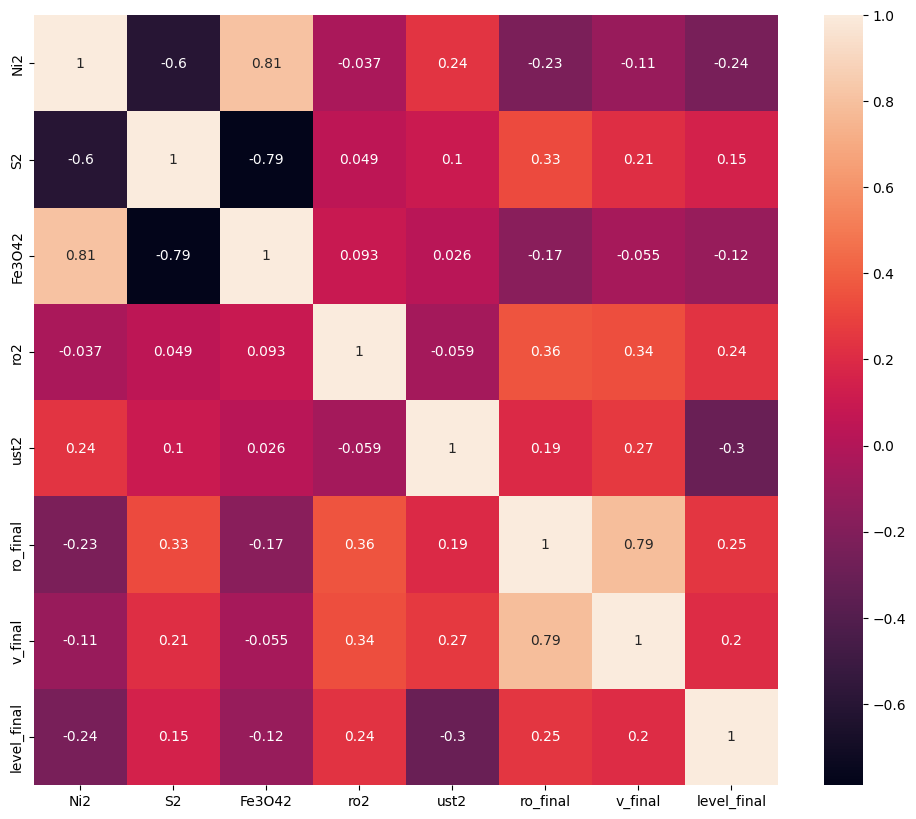

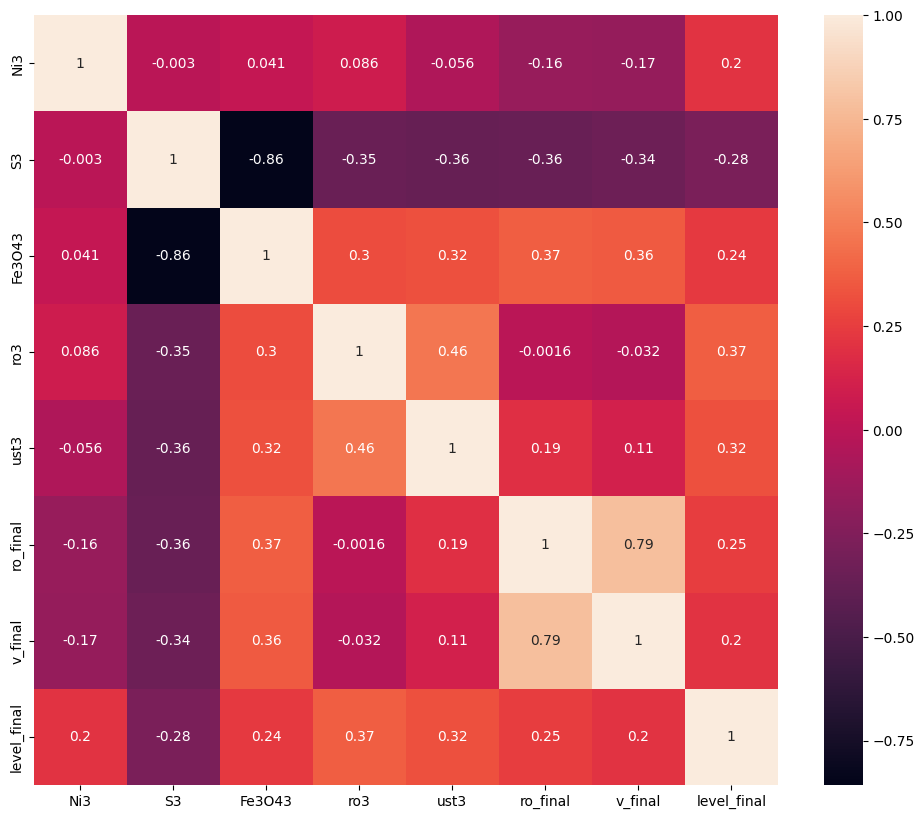

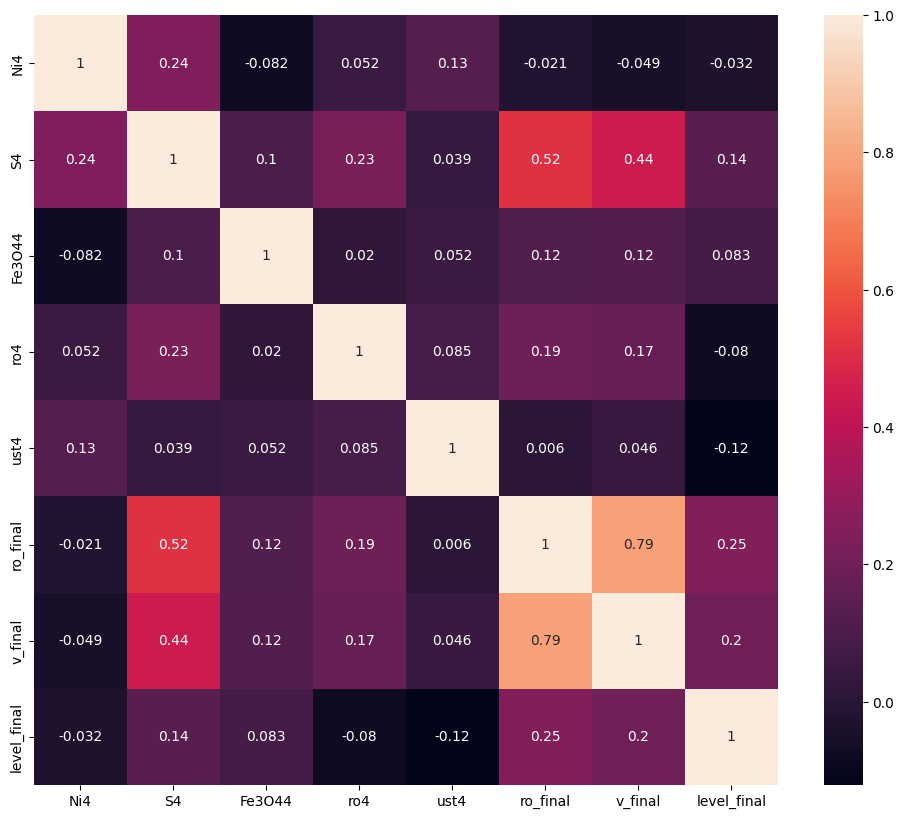

In [9]:
for col in columns_groups:
  plt.figure(figsize=(12,10))
  sns.heatmap(data1[columns_groups[col]].corr(), annot=True)
  plt.show()

Самый наглядный способ анализа - строим графики по группам

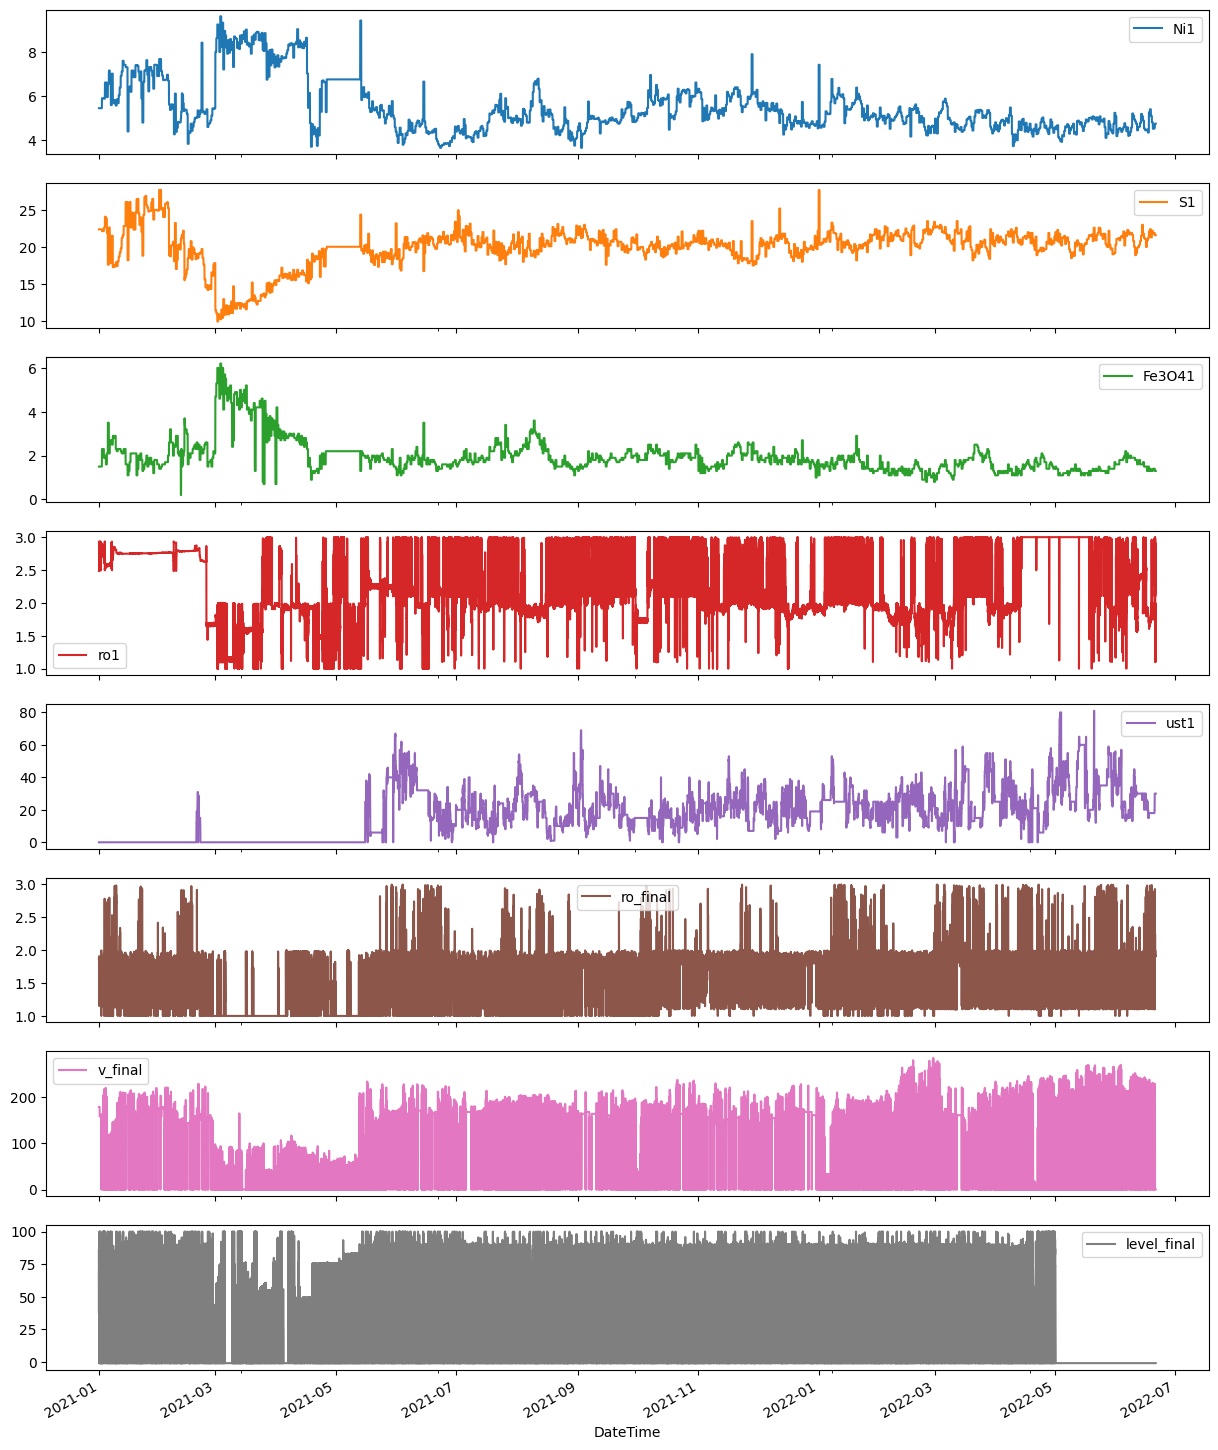

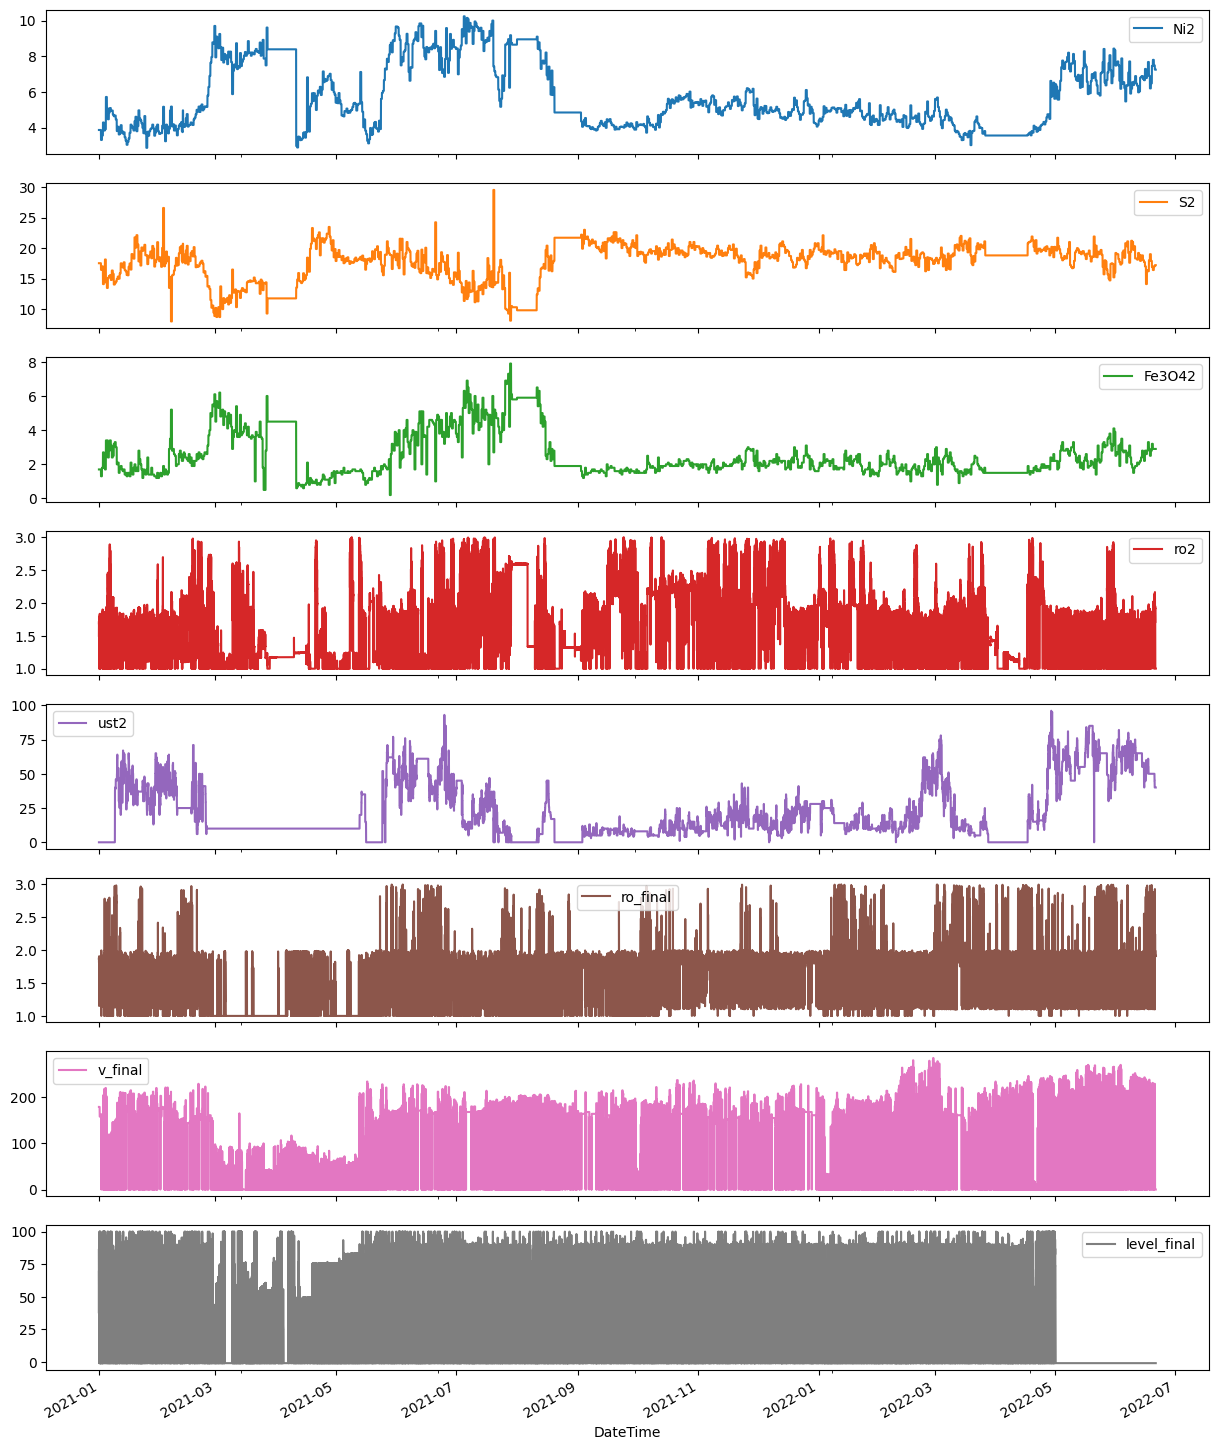

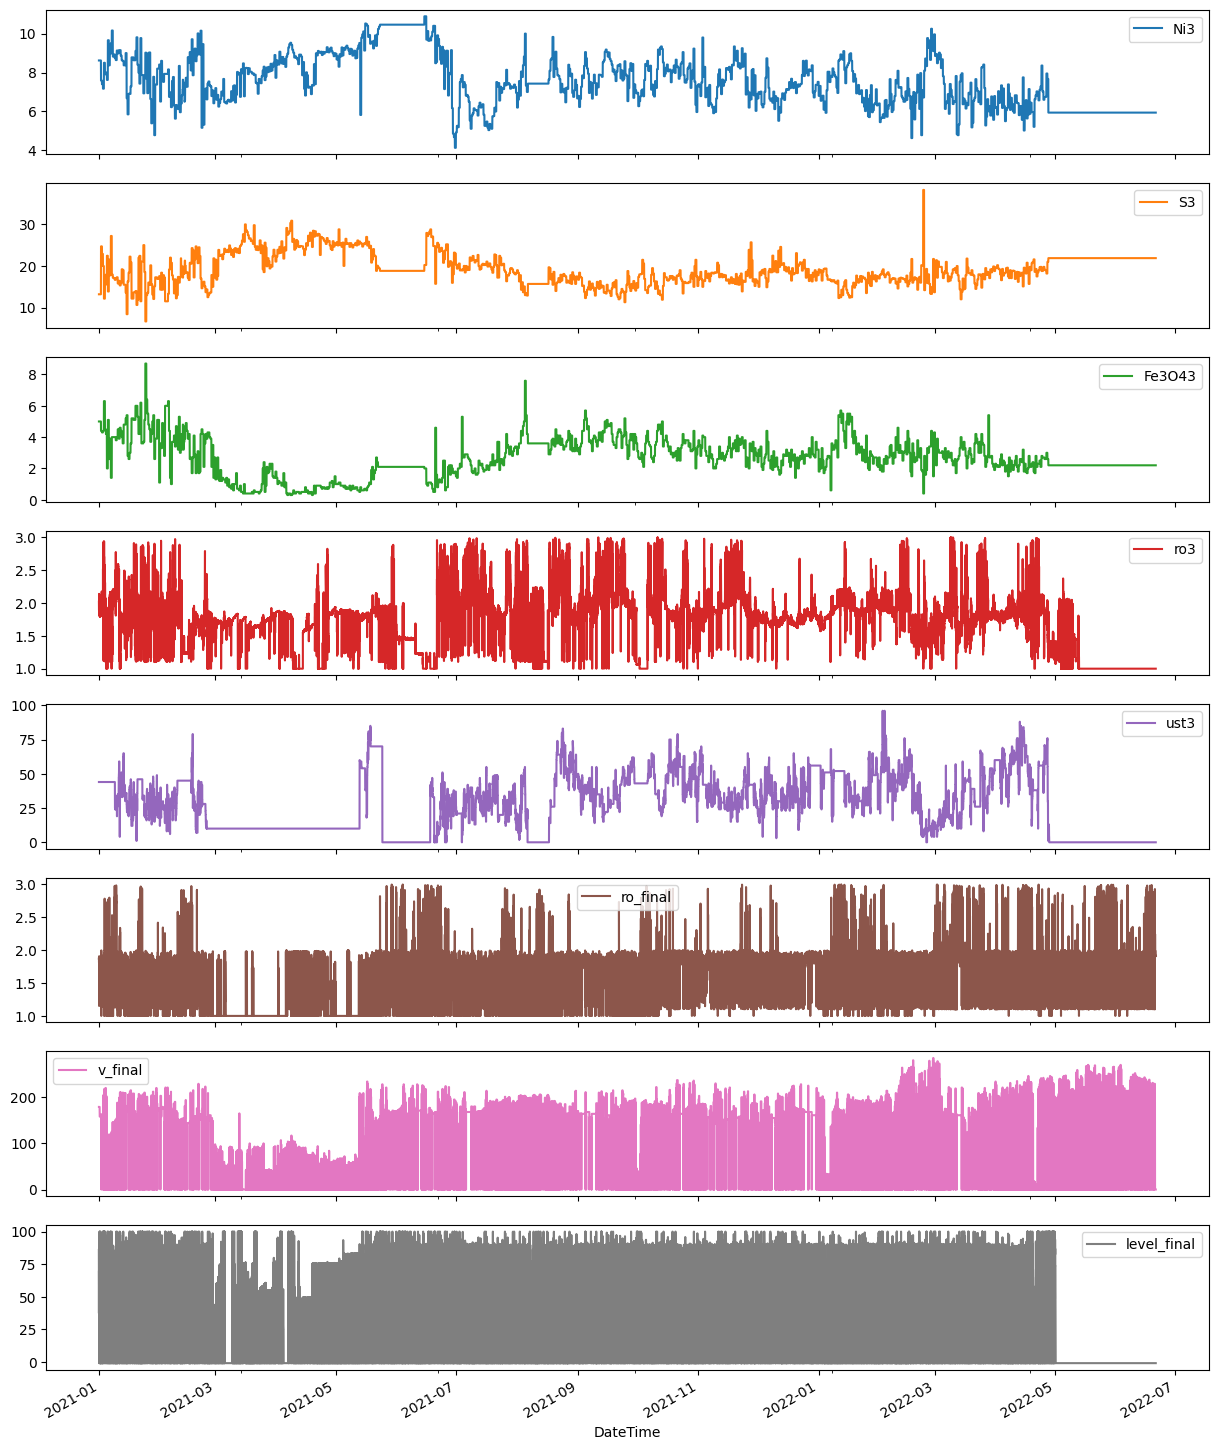

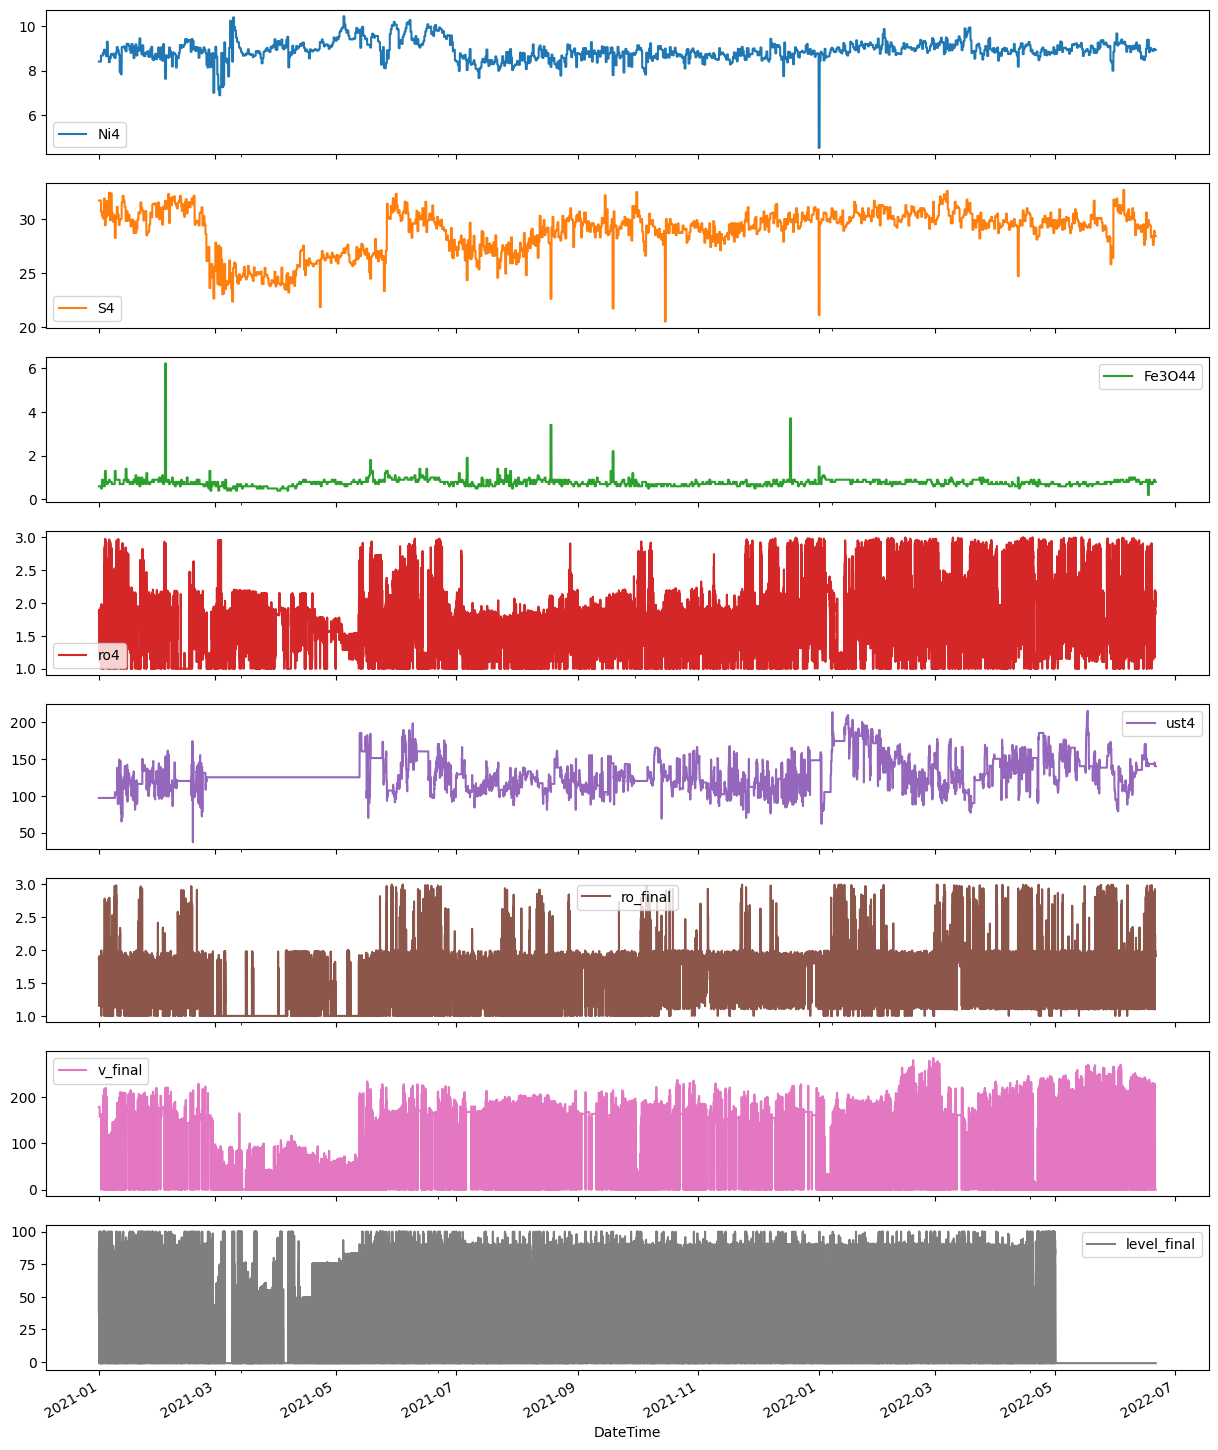

In [10]:
for col in columns_groups:
  data1[columns_groups[col]].plot(subplots=True, figsize=(15, 20), legend='center left')
  plt.show()

Следует отметить, что присутствуют значительные периоды, когда некоторые показатели не менялись продолжительное время (более 12 часов).  
С этим обстоятельством следует бороться, но займемся этим в следующей подзадаче.

Построим боксплоты на предмет выбросов

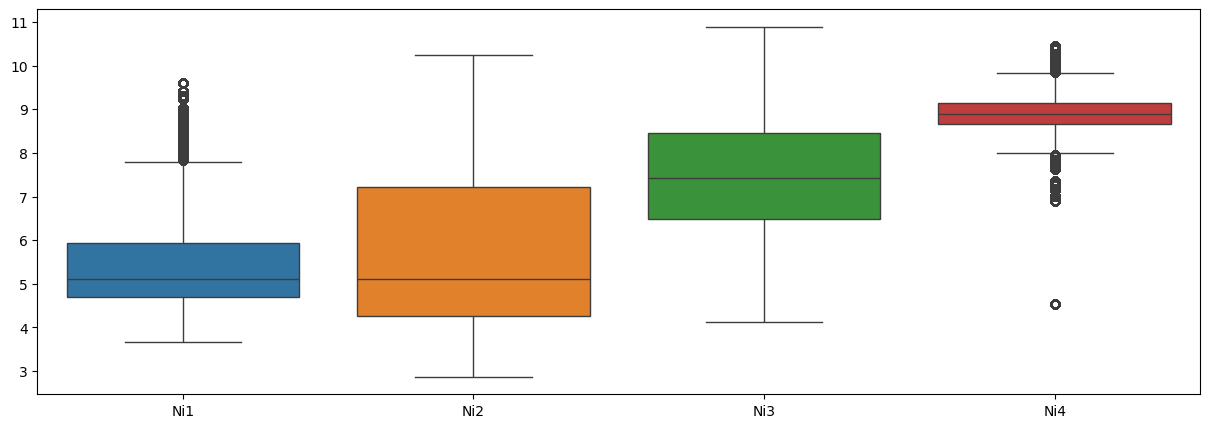

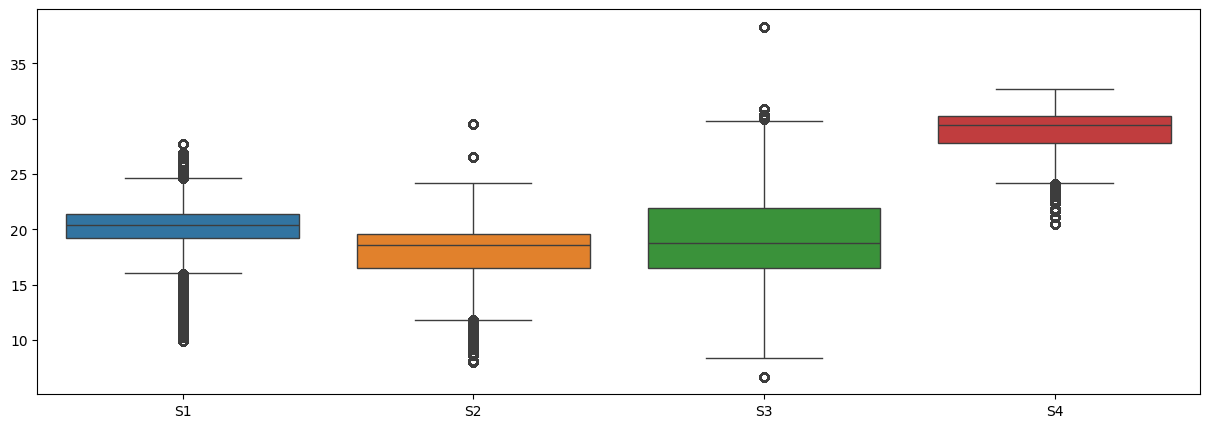

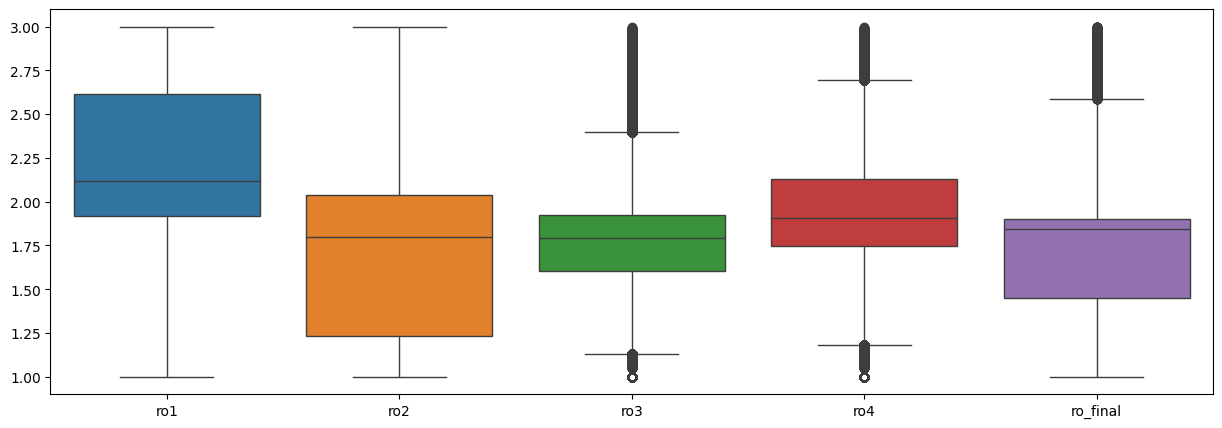

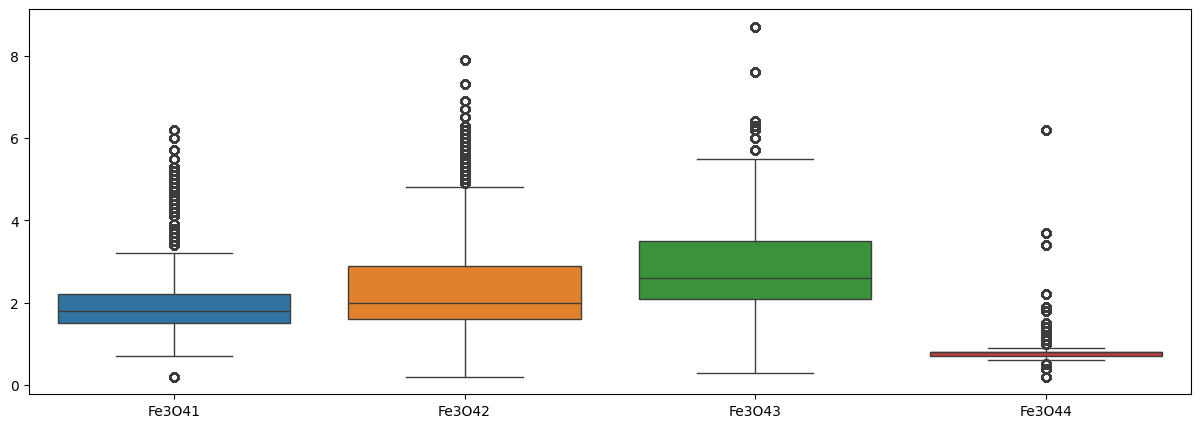

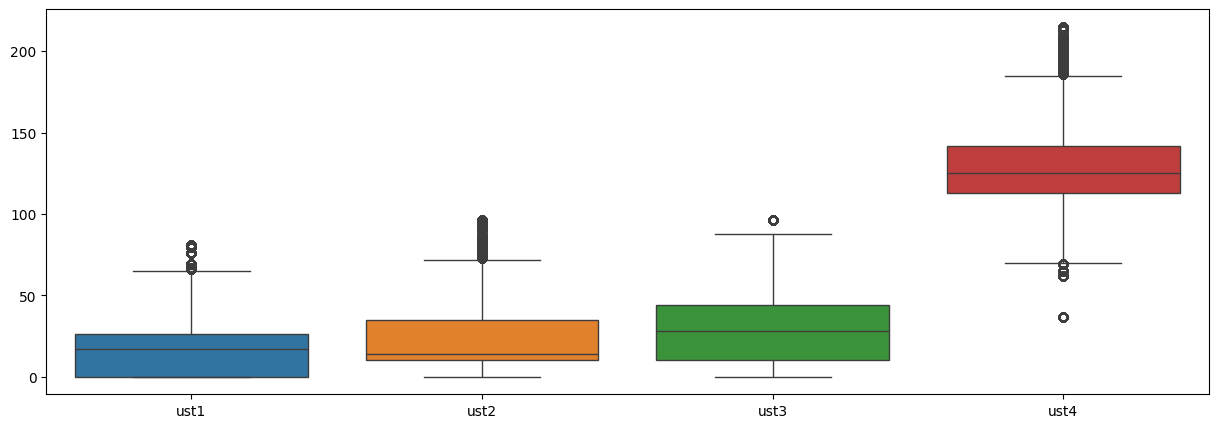

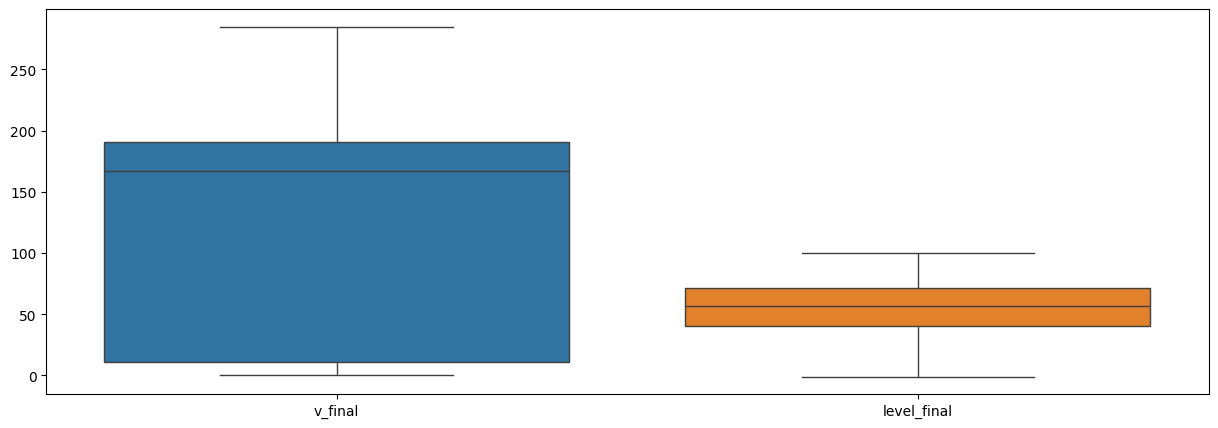

In [11]:
for col in columns_groups_entity:
  fig = plt.figure(figsize = (15,5))
  sns.boxplot(data1.loc[data1.index, columns_groups_entity[col]])
  plt.show()

fig = plt.figure(figsize = (15,5))
sns.boxplot(data1.loc[data1.index, ['v_final', 'level_final']])
plt.show()

Выбросы, как бы, есть, но стоит ли считать их выбросами - вопрос спорный. Нужно анализировать на этапе построения модели.

Проверим на дубликаты (причем сделаем reset_index), иначе - не стоит считать дубликатами.

In [12]:
data1.reset_index()[data1.reset_index().duplicated()]

,DateTime,Ni1,S1,Fe3O41,Ni2,S2,Fe3O42,Ni3,S3,Fe3O43,...,ro2,ro3,ro4,ro_final,ust1,ust2,ust3,ust4,v_final,level_final
18253,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
18254,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
18255,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
18256,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
18257,2021-01-13 16:12:00,7.41,22.84,2.3,3.74,17.67,1.7,8.37,15.51,4.8,...,1.6888,1.65195,1.0000,1.2087,0.0,65.0,38,120.0,199,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681020,2022-04-18 18:38:00,4.48,20.50,1.4,3.57,21.20,1.6,6.45,19.00,2.1,...,2.1404,1.48740,2.3642,1.8465,15.0,32.0,45,152.0,232,87.1307
681022,2022-04-18 18:38:00,4.48,20.50,1.4,3.57,21.20,1.6,6.45,19.00,2.1,...,2.1404,1.48740,2.3642,1.8465,15.0,32.0,45,152.0,232,87.6190
681023,2022-04-18 18:38:00,4.48,20.50,1.4,3.57,21.20,1.6,6.45,19.00,2.1,...,2.1404,1.48740,2.3642,1.8465,15.0,32.0,45,152.0,232,87.6190
681025,2022-04-18 18:38:00,4.48,20.50,1.4,3.57,21.20,1.6,6.45,19.00,2.1,...,2.1404,1.48740,2.3642,1.8465,15.0,32.0,45,152.0,232,88.5714


Получаем 168 строк явно являющихся дубликатами. На этапе построения моделей схлопнем их тем или иным методом.

Рассмотрим еще гистограммы распределения данных, причем в двух вариациях:

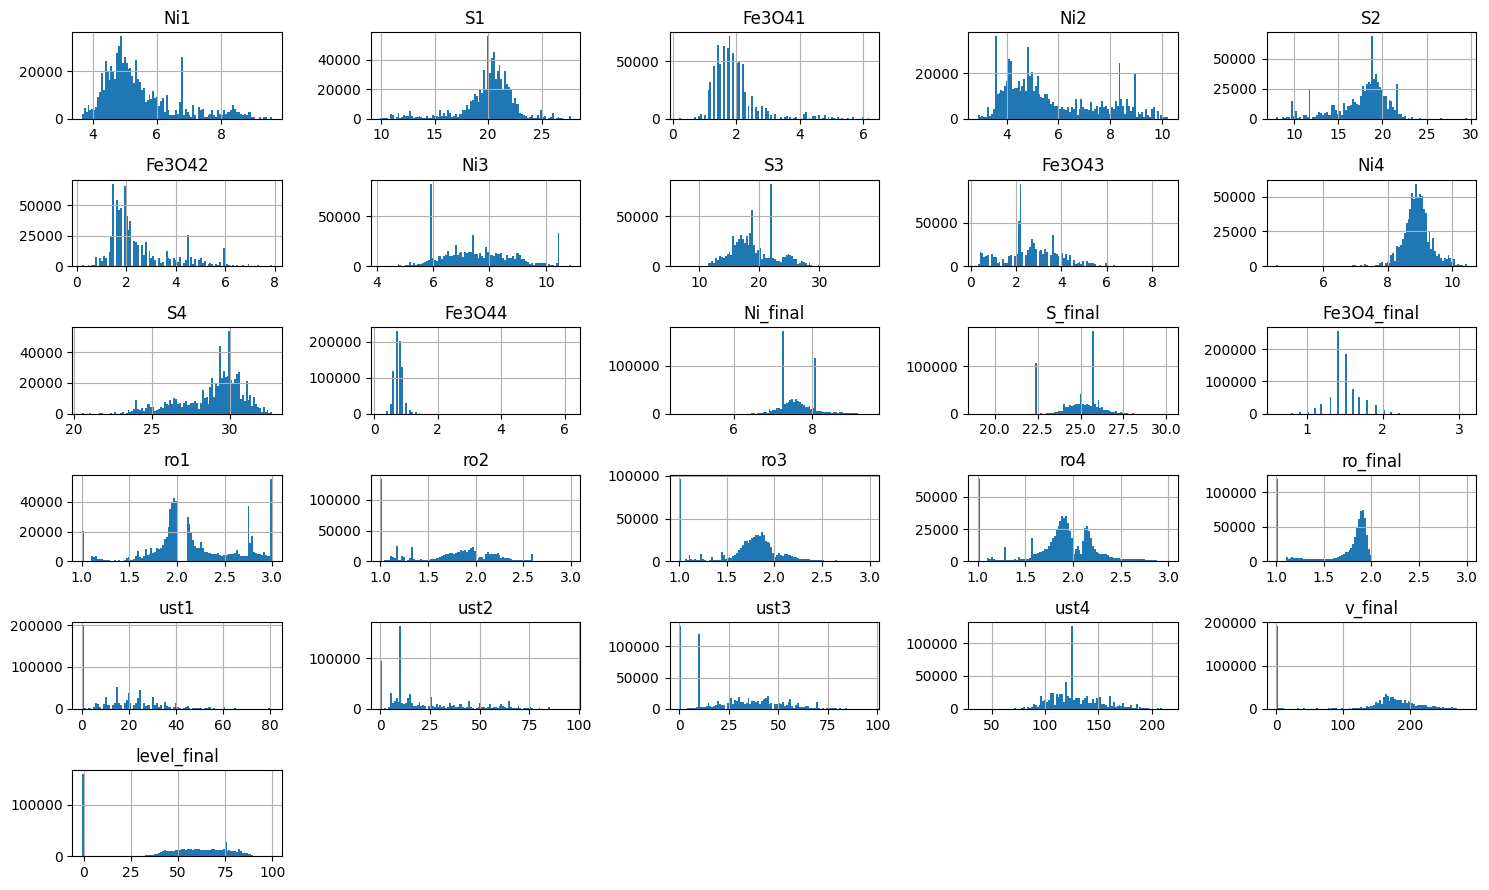

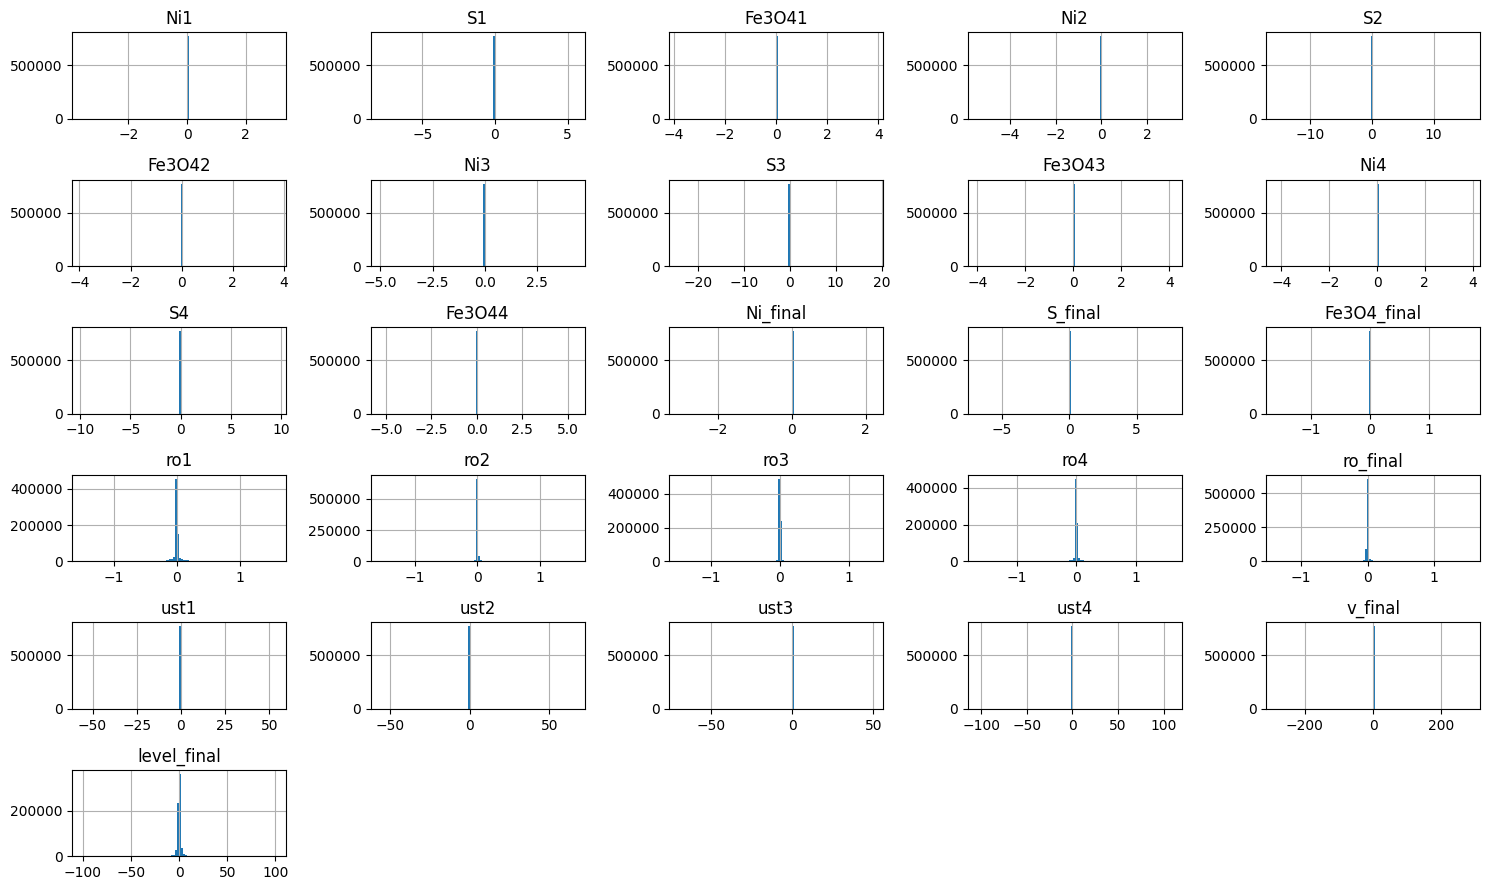

In [13]:
data1.hist(bins=100, figsize=(15, 9))
plt.tight_layout()
plt.show()

(data1 - data1.shift()).hist(bins=100, figsize=(15, 9))
plt.tight_layout()
plt.show()

Простым способом посмотреть распределения приращений не удалось, опять же, оставим этот вопрос на этап моделирования

#### data2

Для data2 результаты будут аналогичными, нет особого смысла проводить EDA повторно, все аномалии будут исправляться на этапе 2

In [14]:
# Код для data2 (потенциальный)

### Выводы

В данных присутствуют:  
1. Несоответствия заданным условиям ($\rho$ больше 2.5)
2. Выбросы (хотя вопрос спорный, неочев)
3. Периоды, когда некоторые показатели не менялись продолжительное время (более 12 часов)
4. Дубликаты  
  
Все это нестрашно, со всем разберемся и победим, но в следующей части выполнения задания.

## Task 2 - physical and mathematical description

### math model 1

$$C_{final,i}=\frac{\sum_{j=1}^{4}(F_j*C_{i,j})}{\sum_{j=1}^{4}F_j}$$
где $C_{final,i}$ - концентрация $i$-го вещества на выходе,  
$F_j$ - поток из $j$-ой емкости (определяемый уставкой $ust_j$),  
$C_{i,j}$ - концентрация $i$-го вещества в $j$-ой емкости

Уравнения для Никеля, Серы и Fe304:
$$Ni_{final}=\frac{F_1*Ni_1 + F_2*Ni_2 + F_3*Ni_3 + F_4*Ni_4}{F_1+F_2+F_3+F_4}$$  
$$S_{final}=\frac{F_1*S_1 + F_2*S_2 + F_3*S_3 + F_4*S_4}{F_1+F_2+F_3+F_4}$$
$$Fe304_{final}=\frac{F_1*Fe304_1 + F_2*Fe304_2 + F_3*Fe304_3 + F_4*Fe304_4}{F_1+F_2+F_3+F_4}$$

<Axes: >

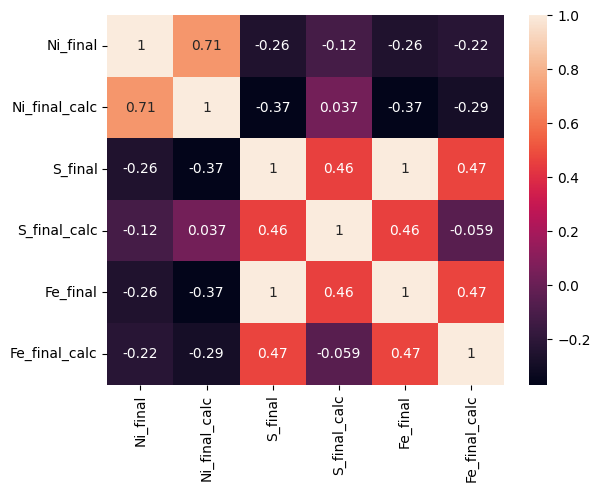

In [15]:
pred_ni = pd.concat([
  data1['Ni_final'],
  (data1['ust1'] * data1['Ni1'] + data1['ust2'] * data1['Ni2'] + \
  data1['ust3'] * data1['Ni3'] + data1['ust4'] * data1['Ni4']) / \
  (data1['ust1'] + data1['ust2'] + data1['ust3'] + data1['ust4'])
], axis=1)
pred_ni.columns = ['Ni_final', 'Ni_final_calc']

pred_S = pd.concat([
  data1['S_final'],
  (data1['ust1'] * data1['S1'] + data1['ust2'] * data1['S2'] + \
  data1['ust3'] * data1['S3'] + data1['ust4'] * data1['S4']) / \
  (data1['ust1'] + data1['ust2'] + data1['ust3'] + data1['ust4'])
], axis=1)
pred_S.columns = ['S_final', 'S_final_calc']

pred_Fe = pd.concat([
  data1['S_final'],
  (data1['ust1'] * data1['Fe3O41'] + data1['ust2'] * data1['Fe3O42'] + \
  data1['ust3'] * data1['Fe3O43'] + data1['ust4'] * data1['Fe3O44']) / \
  (data1['ust1'] + data1['ust2'] + data1['ust3'] + data1['ust4'])
], axis=1)
pred_Fe.columns = ['Fe_final', 'Fe_final_calc']

sns.heatmap(
  pd.concat([
    pred_ni,
    pred_S,
    pred_Fe,
  ], axis=1).corr(),
  annot=True
)

<Axes: xlabel='DateTime'>

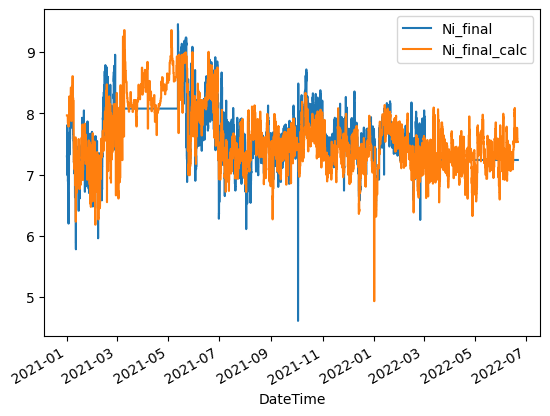

In [16]:
X = pred_ni['Ni_final_calc'].values.reshape(-1, 1)
y = pred_ni['Ni_final'].values

lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(X, y)

pd.concat([pred_ni.iloc[:, 0], pred_ni.iloc[:, 1] * lr.coef_[0]], axis=1).plot()

<Axes: xlabel='DateTime'>

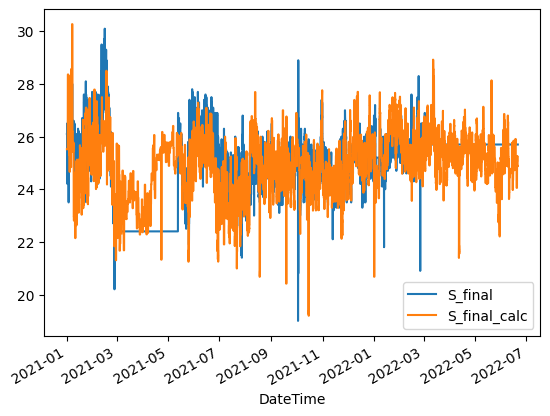

In [17]:
X = pred_S['S_final_calc'].values.reshape(-1, 1)
y = pred_S['S_final'].values

lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(X, y)

pd.concat([pred_S.iloc[:, 0], pred_S.iloc[:, 1] * lr.coef_[0]], axis=1).plot()

<Axes: xlabel='DateTime'>

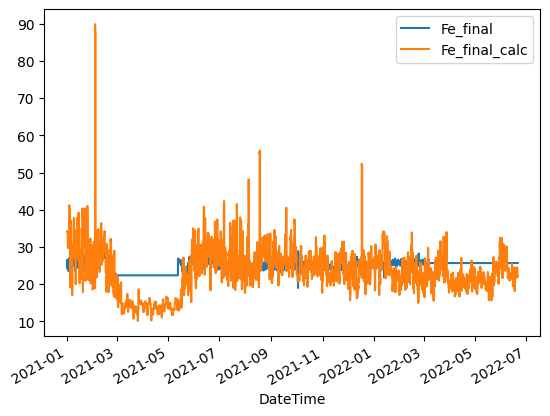

In [18]:
X = pred_Fe['Fe_final_calc'].values.reshape(-1, 1)
y = pred_Fe['Fe_final'].values

lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(X, y)

pd.concat([pred_Fe.iloc[:, 0], pred_Fe.iloc[:, 1] * lr.coef_[0]], axis=1).plot()

### Второе приближение

In [19]:
columns1 = [f'data1_{col}' for col in data1.columns]
columns2 = [f'data2_{col}' for col in data2.columns]

In [20]:
data1.columns = columns1
data2.columns = columns1
data1 = data1[data1 != data2].ffill().dropna(axis=1)

In [21]:
columns1 = [f'data1_{col}' for col in data1.columns]
columns2 = [f'data2_{col}' for col in data2.columns]

In [22]:
data1.columns = columns1
data2.columns = columns2

In [23]:
data_full = pd.concat([data1, data2], axis=1)
columns_list = list(data_full.columns)
new_columns = []
for col in columns_list:
  new_columns.append(
    col.replace('data1_data1', 'data1').replace('data2_data1', 'data2')
  )
# new_columns

In [24]:
data_full.columns = new_columns
data_full.head(3)

,data1_Ni_final,data1_S_final,data1_ro_final,data1_ust2,data1_ust3,data1_ust4,data1_v_final,data1_level_final,data2_Ni1,data2_S1,...,data2_ro2,data2_ro3,data2_ro4,data2_ro_final,data2_ust1,data2_ust2,data2_ust3,data2_ust4,data2_v_final,data2_level_final
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,7.3,26.1,1.8684,0.0,44.0,97.0,179.0,69.2796,5.45,22.39,...,1.68910,2.0167,1.86565,1.8892,0.0,44.0,23.0,167.0,163,64.9328
2021-01-01 00:01:00,7.3,26.1,1.8752,0.0,44.0,97.0,179.0,69.1331,5.45,22.39,...,1.69955,2.0290,1.86145,1.8896,0.0,44.0,23.0,167.0,163,66.4469
2021-01-01 00:02:00,7.3,26.1,1.8635,0.0,44.0,97.0,179.0,66.7399,5.45,22.39,...,1.69980,2.0453,1.85210,1.8833,0.0,44.0,23.0,167.0,163,68.4982


In [25]:
data_full.columns
target = [
  'data1_Ni_final',
  'data1_S_final',
  'data1_ro_final',
  'data1_v_final',
  'data2_Ni_final',
  'data2_S_final',
  'data2_Fe3O4_final',
  'data2_ro_final',
  'data2_level_final'
]
features = list(set(data_full.columns) - set(target))

In [26]:
new_features = features.copy()
for i in tqdm(range(10)):
  for col in data_full[features]:
    new_features.append(f'lag{i}_{col}')
    data_full[f'lag{i}_{col}'] = data_full[col].shift(i)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
data_full.head(3)

,data1_Ni_final,data1_S_final,data1_ro_final,data1_ust2,data1_ust3,data1_ust4,data1_v_final,data1_level_final,data2_Ni1,data2_S1,...,lag9_data2_S4,lag9_data2_v_final,lag9_data2_Fe3O41,lag9_data1_ust4,lag9_data2_Fe3O42,lag9_data2_ust4,lag9_data2_S3,lag9_data2_ro4,lag9_data1_ust2,lag9_data2_Ni3
DateTime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,7.3,26.1,1.8684,0.0,44.0,97.0,179.0,69.2796,5.45,22.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:01:00,7.3,26.1,1.8752,0.0,44.0,97.0,179.0,69.1331,5.45,22.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:02:00,7.3,26.1,1.8635,0.0,44.0,97.0,179.0,66.7399,5.45,22.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data_full[target] = data_full[target].shift(-1)
data_full = data_full.ffill().dropna()

In [29]:
X = data_full[new_features].values
y = data_full[target].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [30]:
lr = LinearRegression(n_jobs=-1, fit_intercept=False)
lr.fit(x_train, y_train)

LinearRegression(fit_intercept=False, n_jobs=-1)

In [31]:
pd.DataFrame(abs(lr.predict(x_train) - y_train) / np.where(y_train == 0, y_train.mean(), y_train), columns=target).max()

data1_Ni_final          0.600050
data1_S_final           0.299669
data1_ro_final          1.050286
data1_v_final         185.678015
data2_Ni_final          0.378199
data2_S_final           0.231307
data2_Fe3O4_final       1.183221
data2_ro_final          1.175189
data2_level_final    1991.560857
dtype: float64

In [32]:
pd.DataFrame(abs(lr.predict(x_test) - y_test) / np.where(y_test == 0, y_test.mean(), y_test), columns=target).max()

data1_Ni_final         0.597913
data1_S_final          0.298741
data1_ro_final         1.051388
data1_v_final        172.404989
data2_Ni_final         0.378106
data2_S_final          0.231292
data2_Fe3O4_final      1.182460
data2_ro_final         1.082836
data2_level_final    936.839231
dtype: float64

Вывод: линейность не справляется :c

#### Третье приближение

In [33]:
data_full = pd.concat([data1, data2], axis=1)
data_full.ffill().dropna()
columns_list = list(data_full.columns)
new_columns = []
for col in columns_list:
  new_columns.append(
    col.replace('data1_data1', 'data1').replace('data2_data1', 'data2')
  )
data_full.columns = new_columns

In [41]:
# Преобразуем данные в NumPy массивы для ускорения
data_full_values = data_full[features].values
target_values = data_full[target].values

# Используем списки пониманий для создания all_x и all_y
all_x = np.array([data_full_values[i:i+50] for i in tqdm(range(len(data_full) - 51))])
all_y = np.array([target_values[i+51] for i in tqdm(range(len(data_full) - 51))])

  0%|          | 0/772016 [00:00<?, ?it/s]

  0%|          | 0/772016 [00:00<?, ?it/s]

In [43]:
x, x_final = all_x[:-10000], all_x[-10000:]
y, y_final = all_y[:-10000], all_y[-10000:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [45]:
x_train.shape, x_test.shape, x_final.shape

((609612, 50, 25), (152404, 50, 25), (10000, 50, 25))

In [46]:
y_train.shape, y_test.shape, y_final.shape

((609612, 9), (152404, 9), (10000, 9))

In [47]:
x_train = torch.Tensor(x_train)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.Tensor(x_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

x_final = torch.Tensor(x_final)
y_final = torch.tensor(y_final, dtype=torch.float32)

print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

print("Shape of x_train:", x_test.shape)
print("Shape of y_train:", y_test.shape)

print("Shape of x_train:", x_final.shape)
print("Shape of y_train:", y_final.shape)

Shape of x_train: torch.Size([609612, 50, 25])
Shape of y_train: torch.Size([609612, 9])
Shape of x_train: torch.Size([152404, 50, 25])
Shape of y_train: torch.Size([152404, 9])
Shape of x_train: torch.Size([10000, 50, 25])
Shape of y_train: torch.Size([10000, 9])


In [56]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Создаем dataset и dataloader
train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)
final_dataset = TimeSeriesDataset(x_final, y_final)

batch_size = 64  # Выбираем подходящий размер батча

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=False)

In [48]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

x_final = x_final.to(device)
y_final = y_final.to(device)

In [57]:
# Создание простой модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Используем последнее значение из последовательности
        return out

# Гиперпараметры
input_size = x_train.shape[2] 
hidden_size = 50  
output_size = y_train.shape[1]  
learning_rate = 0.0001
num_epochs = 100

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 304.2020, Test Loss: 301.9999
Epoch [20/100], Train Loss: 280.7344, Test Loss: 279.9118
Epoch [30/100], Train Loss: 269.7455, Test Loss: 272.1033
Epoch [40/100], Train Loss: 264.0814, Test Loss: 263.2652
Epoch [50/100], Train Loss: 253.9411, Test Loss: 266.1359
Epoch [60/100], Train Loss: 247.0027, Test Loss: 246.6163
Epoch [70/100], Train Loss: 242.9456, Test Loss: 245.2434
Epoch [80/100], Train Loss: 240.5843, Test Loss: 241.0360
Epoch [90/100], Train Loss: 235.8554, Test Loss: 235.9021
Epoch [100/100], Train Loss: 233.2267, Test Loss: 235.7197


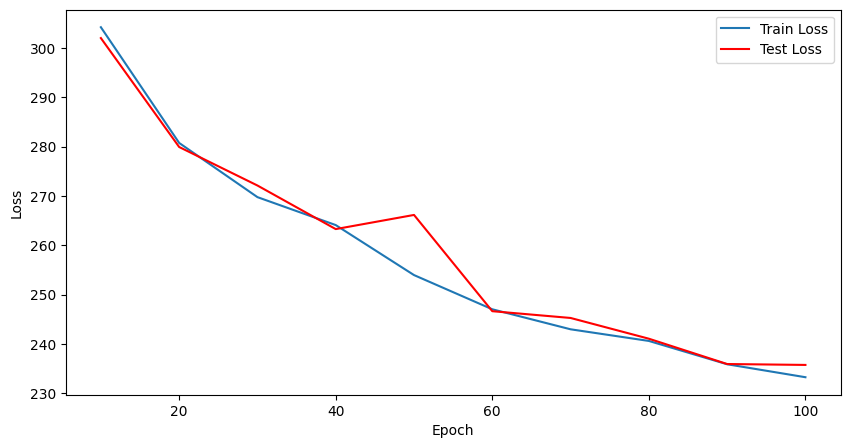

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.51 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 6.11 GiB is allocated by PyTorch, and 854.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [60]:
# Инициализация модели, функции потерь и оптимизатора
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Листы для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            running_test_loss = 0.0
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_test_pred = model(x_batch).squeeze()
                test_loss = criterion(y_test_pred, y_batch)
                running_test_loss += test_loss.item()

            test_loss = running_test_loss / len(test_loader)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(range(10, num_epochs+1, 10), train_losses, label='Train Loss')
plt.plot(range(10, num_epochs+1, 10), test_losses, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Пример предсказания
model.eval()
with torch.no_grad():
    test_predictions = model(x_test.to(device)).squeeze().cpu().numpy()
    # print("Test Predictions:", test_predictions)

In [70]:
model.eval()
with torch.no_grad():
  final_predictions = model(x_final).squeeze().cpu().numpy()

pd.DataFrame(abs(final_predictions - y_final.cpu().numpy()), columns=target).describe()

,data1_Ni_final,data1_S_final,data1_ro_final,data1_v_final,data2_Ni_final,data2_S_final,data2_Fe3O4_final,data2_ro_final,data2_level_final
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.832249e-02,0.227860,0.157311,40.282730,0.082353,0.157201,0.032401,0.219182,2.357277
std,6.416419e-02,0.096644,0.197911,42.919323,0.051352,0.089070,0.016190,0.112982,2.287538
min,9.536743e-07,0.000185,0.000000,0.001144,0.000008,0.000032,0.000016,0.000040,0.001604
25%,2.485156e-02,0.173423,0.036130,16.710442,0.048625,0.107434,0.019148,0.159984,0.589863
50%,4.526901e-02,0.238851,0.070924,24.815369,0.069243,0.145712,0.035105,0.200836,1.618655
75%,8.974493e-02,0.267540,0.204887,47.041412,0.110493,0.171488,0.044391,0.227969,3.395735
max,3.049097e-01,0.747623,1.134504,223.829102,0.264585,0.674246,0.157629,0.965809,14.141373


In [71]:
input_size = x_train.shape[2] 
hidden_size = 50 
output_size = y_train.shape[1] 
learning_rate = 0.001
num_epochs = 200

# Инициализация модели, функции потерь и оптимизатора
model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Листы для хранения значений потерь
train_losses = []
test_losses = []

# Обучение модели
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            running_test_loss = 0.0
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_test_pred = model(x_batch).squeeze()
                test_loss = criterion(y_test_pred, y_batch)
                running_test_loss += test_loss.item()

            test_loss = running_test_loss / len(test_loader)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(range(10, num_epochs+1, 10), train_losses, label='Train Loss')
plt.plot(range(10, num_epochs+1, 10), test_losses, label='Test Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Пример предсказания
model.eval()
with torch.no_grad():
    test_predictions = model(x_test.to(device)).squeeze().cpu().numpy()
    # print("Test Predictions:", test_predictions)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10/200], Train Loss: 334.5207, Test Loss: 327.1853
Epoch [20/200], Train Loss: 327.8953, Test Loss: 320.7177
Epoch [30/200], Train Loss: 323.3781, Test Loss: 325.2410
Epoch [40/200], Train Loss: 318.1886, Test Loss: 327.1149
Epoch [50/200], Train Loss: 302.2396, Test Loss: 302.2328
Epoch [60/200], Train Loss: 295.9489, Test Loss: 316.1461
Epoch [70/200], Train Loss: 296.8857, Test Loss: 291.0497
Epoch [80/200], Train Loss: 293.8898, Test Loss: 309.9092
Epoch [90/200], Train Loss: 291.0522, Test Loss: 290.3720
Epoch [100/200], Train Loss: 289.5184, Test Loss: 344.8310
Epoch [110/200], Train Loss: 289.8283, Test Loss: 287.6396
Epoch [120/200], Train Loss: 288.5612, Test Loss: 287.8320


KeyboardInterrupt: 

In [72]:
model.eval()
with torch.no_grad():
  final_predictions = model(x_final).squeeze().cpu().numpy()

pd.DataFrame(abs(final_predictions - y_final.cpu().numpy()), columns=target).describe()

,data1_Ni_final,data1_S_final,data1_ro_final,data1_v_final,data2_Ni_final,data2_S_final,data2_Fe3O4_final,data2_ro_final,data2_level_final
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.079187,0.092229,0.159910,43.811142,0.035735,0.063670,0.021572,0.165550,1.683236
std,0.030652,0.113782,0.206840,42.699402,0.022196,0.056995,0.016333,0.140493,1.098052
min,0.000084,0.000172,0.000008,0.006729,0.000157,0.000011,0.000003,0.000128,0.126098
25%,0.066600,0.030386,0.035672,21.047646,0.020884,0.012422,0.009225,0.088086,0.781713
50%,0.068917,0.048372,0.065731,31.722351,0.031357,0.066202,0.022131,0.112155,0.975561
75%,0.088766,0.129946,0.195594,47.744095,0.038026,0.089257,0.023576,0.154781,2.705801
max,0.221322,0.544584,1.355756,232.039902,0.156909,0.308653,0.104569,0.744870,5.241690


Выводы по задаче 2:
1. Линейная регрессия вполне нормально себя проявляет
2. Если поэксперементировать с нелинейными зависимостями, можно создать +- интерпретируемую модель
3. LSTM так же показывает себя хорошо, но мощностей, отнюдь, не хватает
4. хуже всего пректится v_final, нужно подробнее поковырять эти данные
5. можно предложить строить отдельную модель непосредственно для v_final, которая, потенциально,  
будет работать лучше, взять больший временной лаг

In [102]:
v_final.corr().iloc[:, 0].plot()